# LangChain Components 🦜️🔗 with Vertex AI and Gemini

## Objectives

This notebook provides an understanding of [Langchain](https://langchain.com/) components with Vertex AI Gemini APIs.

- Learn about LangChain and basic LangChain components
- Learn how to use Vertex AI with LangChain
- Learn how to call various Google LLM models using LangChain
- Learn how to create prompts and work with documents using LangChain


**Acknowledgment:**

- Adapted from [LangChain Cookbook](https://github.com/gkamradt/langchain-tutorials) from [Greg Kamradt](https://twitter.com/GregKamradt)
- [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)


## What is LangChain? <a name="intro-to-langchain"/>

> LangChain is a framework for developing applications powered by large language models (LLMs).

**TL;DR** LangChain makes the complicated parts of working & building with language models easier. It helps do this in two ways:

1. **Integration** - Brings external data, such as your files, other applications, and API data, to LLMs
2. **Agents** - Allows LLMs to interact with its environment via decision making and use LLMs to help decide which action to take next

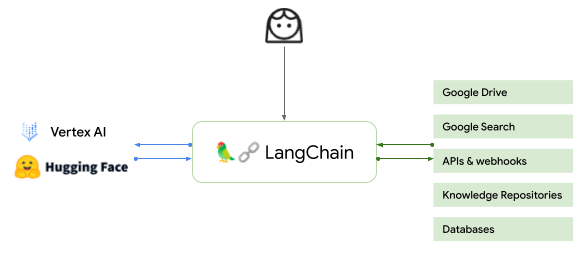


To build effective Generative AI applications, it is key to enable LLMs to interact with external systems. This makes models data-aware and agentic, meaning they can understand, reason, and use data to take action in a meaningful way. The external systems could be public data corpus, private knowledge repositories, databases, applications, APIs, or access to the public internet via Google Search.

Here are a few patterns where LLMs can be augmented with other systems:

- Convert natural language to SQL, executing the SQL on database, analyze and present the results
- Calling an external webhook or API based on the user query
- Synthesize outputs from multiple models, or chain the models in a specific order

It may look trivial to plumb these calls together and orchestrate them but it becomes a mundane task to write glue code again and again e.g. for every different data connector or a new model. That’s where LangChain comes in!

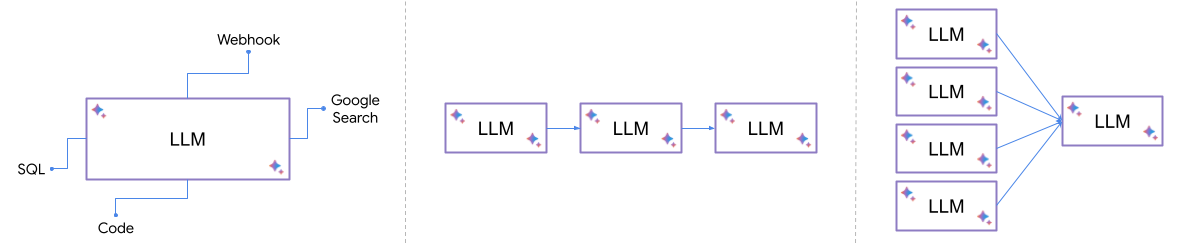


#### Why LangChain?

LangChain’s modular implementation of components and common patterns combining these components makes it easier to build complex applications based on LLMs. LangChain enables these models to connect to data sources and systems as agents to take action.

1. **Components** are abstractions that works to bring external data, such as your documents, databases, applications, APIs to language models. LangChain makes it easy to swap out abstractions and components necessary to work with LLMs.

2. **Agents** enable language models to communicate with its environment, where the model then decides the next action to take. LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together.

Though LLMs can be straightforward (text-in, text-out) you'll quickly run into friction points that LangChain helps with once you develop more complicated applications.

#### LangChain & Vertex AI

[Vertex AI Generative AI models](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) — Gemini and Embeddings — are officially integrated with the [LangChain Python SDK](https://python.langchain.com/docs/introduction/), making it convenient to build applications using Gemini models with the ease of use and flexibility of LangChain.

- [LangChain Google Integrations](https://python.langchain.com/docs/integrations/providers/google/)

### Import libraries


In [ ]:
PROJECT_ID = !gcloud config list --format 'value(core.project)'
PROJECT_ID = PROJECT_ID[0]
REGION = "us-central1"

In [ ]:
import uuid

from IPython.display import Markdown
from langchain import hub
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import (
    GutenbergLoader,
    HNLoader,
    UnstructuredURLLoader,
)
from langchain.output_parsers import (
    PydanticOutputParser,
    ResponseSchema,
    StructuredOutputParser,
)
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.few_shot import FewShotPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_google_vertexai import ChatVertexAI, VertexAI, VertexAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from pydantic import BaseModel, Field

Define LangChain Models using the Vertex AI Gemini API for Text, Chat and Vertex AI Embeddings for Text

In [ ]:
# LLM model
llm = VertexAI(
    model_name="gemini-2.0-flash",
    verbose=True,
)

# Chat
chat = ChatVertexAI(model="gemini-2.0-flash")

# Embedding
embeddings = VertexAIEmbeddings("text-embedding-005")

# LangChain Components <a name="langchain"/>

Let’s take a quick tour of LangChain framework and concepts to be aware of. LangChain offers a variety of modules that can be used to create language model applications. These modules can be combined to create more complex applications, or can be used individually for simpler applications.

- **Model I/O** are the building block of LangChain providing an interface to different types of AI models. Large Language Models (LLMs), Chat and Text Embeddings models are supported model types. Prompts refers to the input to the model, which is typically constructed from multiple components. LangChain provides interfaces to construct and work with prompts easily - Prompt Templates, Example Selectors and Output Parsers.
- **Retrieval** help LLMs interact with documents by providing a way to structure them. LangChain provides Document Loaders to load documents, Text Splitters to split documents into smaller chunks, Vector Stores to store documents as embeddings, and Retrievers to fetch relevant documents.
- **Composition** Higher-level components that combine other arbitrary systems and/or or LangChain primitives together. This includes, **memory** that provides a construct for storing and retrieving messages during a conversation which can be either short term or long term. **Chains** let you combine modular components (or other chains) in a specific order to complete a task. And, **agents** are a powerful construct in LangChain allowing LLMs to communicate with external systems via Tools and observe and decide on the best course of action to complete a given task.
- **Additional** includes Memory and Callbacks. Memory lets you persist application state between runs of a chain. And callbacks, let you log and stream steps in a workflow.


## Model I/O <a name="langchain-model-io"/>

The core element of any language model application is...the model. LangChain gives you the building blocks to interface with any language model.

### Models <a name="langchain-models"/>

LangChain supports 3 model primitives:

- LLMs
- Chat Models
- Text Embedding Models

VertexAI exposes all foundational models available in google cloud:
- Gemini
- Gemma
- 3rd party models (Llama, Claude, Mistral...)
- Embeddings for Text

### Language Model <a name="langchain-models-language"/>

Text is the natural language way to interact with LLMs. This is one of the fundamental ways to interact with LLMs. Let's start by asking the LLM some information. Language model provide a text in ➡️ text out interface! Let's call Gemini models to work with text input.

[LangChain LLMs](https://python.langchain.com/docs/integrations/llms/google_vertex_ai_palm) are integrated with [Vertex AI models](https://cloud.google.com/vertex-ai/docs/generative-ai/text/text-overview).


In [ ]:
my_text = "What are the different varieties of tomatoes?"

llm.invoke(my_text)

If you want the response to be formatted well, you can always use the `Markdown()` function to render it well

In [ ]:
Markdown(llm.invoke(my_text))

### Chat Model <a name="langchain-models-chat"/>


Chat is like text, but specified with a message type (System, Human, AI)

- **System** - Helpful context that tells the AI what to do
- **Human** - Messages intended to represent the user
- **AI** - Messages showing what the AI responded with

For more information, see [LangChain Documentation for Chat Models](https://python.langchain.com/docs/modules/model_io/chat).



In [ ]:
chat.invoke([HumanMessage(content="Hello")]).pretty_print()

In [ ]:
messages = [
    SystemMessage(
        content="You are a chef who will help the user figure out what they can eat, provide a list with numbers to choose from."
    ),
    HumanMessage(content="I like tomatoes, What can I make with tomatoes?"),
]
res = chat.invoke(messages)
print("Response from the Chat LLM:\n", res.content)
# adding the response from the LLM to the messages
messages.append(AIMessage(content=str(res.content)))
print("\nMessages history:\n", messages)

In [ ]:
messages.append(HumanMessage(content="What is the recipe for option 3?"))
res = chat.invoke(messages)
print(res.content)
# adding the response from the LLM to the messages
messages.append(AIMessage(content=str(res.content)))
print("\nMessages history:\n", messages)

In [ ]:
messages.append(HumanMessage(content="How many servings does this make?"))
res = chat.invoke(messages)
print(res.content)
# adding the response from the LLM to the messages
messages.append(AIMessage(content=str(res.content)))
print("\nMessages history:\n", messages)

You can also pass more chat history with responses from the AI by appending the responses to the content as shown above.

### Text Embedding Model <a name="langchain-models-text-embeddings"/>

[Embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings) are a way of representing data–almost any kind of data, like text, images, videos, users, music, whatever–as points in space where the locations of those points in space are semantically meaningful. Embeddings transform your text into a vector (a series of numbers that hold the semantic 'meaning' of your text). Vectors are often used when comparing two pieces of text together. An [embedding](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture) is a relatively low-dimensional space into which you can translate high-dimensional vectors.

[LangChain Text Embedding Model](https://python.langchain.com/docs/how_to/embed_text/) is integrated with [Vertex AI Embedding API for Text](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings).

_BTW: Semantic means 'relating to meaning in language or logic.'_

In [ ]:
text = "Tomato Soup"

In [ ]:
text_embedding = embeddings.embed_query(text)
print(f"Your embedding is length {len(text_embedding)}")
print(f"Here's a sample: {text_embedding[:5]}...")

## Prompts <a name="langchain-prompts"/>

Prompts are text used as instructions to a LLM.

In [ ]:
prompt = """
Tomato is a vegetable.

What is wrong with that statement?
"""

Markdown(llm.invoke(prompt))

### Prompt Template <a name="langchain-prompts-template"/>

[Prompt Template](https://python.langchain.com/docs/concepts/prompt_templates/) is an object that helps to create prompts based on a combination of user input, other non-static information and a fixed template string.

Think of it as an [`f-string`](https://realpython.com/python-f-strings/) in Python but for prompts

In [ ]:
# Notice "dish_name" below, that is a placeholder for another value later
template = """
I really want to cook {dish_name}. What is the recipe for it?

Respond with a simple recipe that is ideal for beginner cooks.
"""

prompt = PromptTemplate(
    input_variables=["dish_name"],
    template=template,
)

final_prompt = prompt.format(dish_name="Bruschetta")

print(f"Final Prompt: {final_prompt}")
print("-----------")
print(f"LLM Output: {llm.invoke(final_prompt)}")

### Example Selectors <a name="langchain-prompts-example-selectors"/>

[Example selectors](https://python.langchain.com/en/latest/modules/prompts/example_selectors.html) are an easy way to select from a series of examples to dynamically place in-context information into your prompt. Often used when the task is nuanced or has a large list of examples.

Check out different types of example selectors [here](https://python.langchain.com/docs/how_to/#example-selectors).


In [ ]:
example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Example Input: {input}\nExample Output: {output}",
)

# Some examples of how fruits or vegetables taste
examples = [
    {"input": "tomato", "output": "tangy"},
    {"input": "carrots", "output": "sweet"},
    {"input": "kale", "output": "bitter"},
    {"input": "rhubarb", "output": "sour"},
    {"input": "asparagus", "output": "grassey"},
]

Now that we have provided a few examples, we will use `SemanticSimilarityExampleSelector`. This function will select examples that are semantically similar to the examples that we provided. [SemanticSimilarityExampleSelector](https://python.langchain.com/docs/how_to/example_selectors_similarity/) requires a list of examples (defined above), an embedding model and the VectorStore Class in order to generate the result.

In [ ]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples we provide.
    examples,
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    embeddings,
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS,
    # This is the number of examples to produce.
    k=2,
)

In [ ]:
similar_prompt = FewShotPromptTemplate(
    # The object that will help select examples
    example_selector=example_selector,
    # Your prompt
    example_prompt=example_prompt,
    # Customizations that will be added to the top and bottom of your prompt
    prefix="Give the way a vegetable/fruit taste",
    suffix="Input: {noun}\nOutput:",
    # What inputs your prompt will receive
    input_variables=["noun"],
)

In [ ]:
# Select a fruit or vegetable!
my_noun = "orange"

print(similar_prompt.format(noun=my_noun))

In [ ]:
llm.invoke(similar_prompt.format(noun=my_noun))

### Output Parsers <a name="langchain-prompts-output-parsers"/>

[Output Parsers](https://python.langchain.com/docs/concepts/output_parsers/) help to format the output of a model. Usually used for structured output.

Two main ideas:

**1. Format Instructions**: An autogenerated prompt that tells the LLM how to format it's response based off desired result

**2. Parser**: A method to extract model's text output into a desired structure (usually json)

In the following cells, we'll take a look at `ResponseSchema` and `StructuredOutputParser`. This output parser can be used when you want to return multiple fields. While the Pydantic/JSON parser is more powerful, this is useful for less powerful models.


In [ ]:
# How you would like your reponse structured. This is basically a fancy prompt template
response_schemas = [
    ResponseSchema(
        name="bad_string",
        description="This a poorly formatted user input string",
    ),
    ResponseSchema(
        name="good_string",
        description="This is your response, a reformatted response",
    ),
]

# How you would like to parse your output
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [ ]:
# See the prompt template you created for formatting
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

In [ ]:
template = """
You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly including country, city and state names

{format_instructions}

% USER INPUT:
{user_input}

YOUR RESPONSE:
"""

prompt = PromptTemplate(
    input_variables=["user_input"],
    partial_variables={"format_instructions": format_instructions},
    template=template,
)

promptValue = prompt.format(user_input="welcom to my ktchn!")

print(promptValue)

In [ ]:
llm_output = llm.invoke(promptValue)
llm_output

In [ ]:
output_parser.parse(llm_output)

## Data Loaders <a name="langchain-retrieval"/>
 
Data loaders help you load various data to add context to the LLMs.

### Documents <a name="langchain-components-documents"/>

Document in LangChain refers to an unstructured text consisting of `page_content` referring to the content of the data and `metadata` (data describing attributes of page content).


In [ ]:
Document(
    page_content="This is the recipe for a quick and easy tomato soup.",
    metadata={
        "page_number": 2,
        "recipe_source": "mom's recipe",
    },
)

### Document Loaders <a name="langchain-indexes-document-loaders"/>

Document loaders are ways to import data from other sources. See the [large](https://python.langchain.com/docs/integrations/document_loaders/) of document loaders here. Document loaders can be used to provide more context to the LLM especially data that the foundation LLM might not be trained on. This could be a webpage, a specific URL, an offline document etc. 


Here are a few examples of the loaders you can try. 


**Books from Gutenberg Project**

In [ ]:
loader = GutenbergLoader("https://www.gutenberg.org/cache/epub/2148/pg2148.txt")

data = loader.load()

In [ ]:
print(data[0].page_content[1855:1984])

**URLs and webpages**

Let's try it out with [Andrew Ng's website](https://www.andrewng.org/)

In [ ]:
urls = [
    "https://www.andrewng.org/",
]

loader = UnstructuredURLLoader(urls=urls)

webpage_data = loader.load()

webpage_data[0].page_content

### Text Splitters <a name="langchain-indexes-text-splitters"/>

[Text Splitters](https://python.langchain.com/docs/concepts/text_splitters/) are a way to deal with input token limits of LLMs by splitting text into chunks.

There are many ways you could split your text into chunks, experiment with [different ones](https://python.langchain.com/docs/how_to/#text-splitters) to see which is best for your use case.


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=20,
)

texts = text_splitter.split_documents(webpage_data)

In [ ]:
print(f"You have {len(texts)} documents")

In [ ]:
print("Preview:")
print(texts[0].page_content, "\n")
print(texts[1].page_content)

## Memory <a name="langchain-memory"/>

[Memory](https://python.langchain.com/docs/how_to/chatbots_memory/) is the concept of storing and retrieving data in the process of a conversation. Memory helps LLMs remember information you've chatted about in the past or more complicated information retrieval.

### Explicit Memory passing <a name="memorypassing"/>
The simplest form of memory is simply passing chat history messages into a chain. Here's an example:

In [ ]:
ai_msg = llm.invoke(
    [
        HumanMessage(content="Where is deep dish pizza originally from?"),
        AIMessage(
            content="Deep dish pizza is originally from **Chicago, Illinois**."
        ),
        HumanMessage(content="What did you just say?"),
    ]
)
print(ai_msg)

### Memory with langGraph <a name="langgraph"/>
The previous examples pass messages to the chain (and model) explicitly. This is a completely acceptable approach, but it does require external management of new messages. <br>
LangChain also provides a way to build applications that have memory using LangGraph's [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/). You can [enable persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) in LangGraph applications by providing a checkpointer when compiling the graph.

In order to use it, you need to:
- Define a new graph with `StateGraph`
- Define the function that calls the model
- Define the two nodes we will cycle between and add them to the graph
- Compile the graph adding memory

In [ ]:
workflow = StateGraph(state_schema=MessagesState)


def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": AIMessage(content=response)}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

The thread id is a unique key that identifies this particular conversation. <br>
We'll just generate a random uuid here.This enables a single application to manage conversations among multiple users.

In [ ]:
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}

In [ ]:
def send_message(input_message):
    for event in app.stream(
        {"messages": input_message}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

Let's try a multi-turn conversation and check if the memory is successfully saved.

In [ ]:
input_message = HumanMessage(content="Hi there!")
send_message(input_message)

In [ ]:
input_message = HumanMessage(
    content="Where is deep dish pizza originally from?"
)
send_message(input_message)

In [ ]:
input_message = HumanMessage(
    content="What are some other popular dishes from Chicago?"
)
send_message(input_message)

In [ ]:
input_message = HumanMessage(content="What question did I ask first?")
send_message(input_message)

## Chains ⛓️⛓️⛓️ <a name="langchain-chains"/>

Chains are a generic concept in LangChain allowing to combine different LLM calls and action automatically.

Ex:

```
Summary #1, Summary #2, Summary #3 --> Final Summary
```

You can simply define a chain using Python `|` operator like:

```python
first_step | second_step | third_step ...
```

### Simple sequential chains with `|` operator <a name="sequentialchains"/>

Sequential chains are a series of chains, called in deterministic order. Each step uses the output of an LLM as an input into another. Good for breaking up tasks (and keeping the LLM focused).


In [ ]:
template = """Your job is to come up with a classic dish from the area that the users suggests.
% USER LOCATION
{user_location}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(
    input_variables=["user_location"], template=template
)

# Holds my 'location' chain
location_chain = prompt_template | llm

In [ ]:
template = """Given a meal, give a short and simple recipe on how to make that dish at home.
% MEAL
{user_meal}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(
    input_variables=["user_meal"], template=template
)

# Holds my 'meal' chain
meal_chain = prompt_template | llm

Now we can combine these two chains sequentially.

In [ ]:
overall_chain = location_chain | meal_chain

In [ ]:
review = overall_chain.invoke("Rome")
Markdown(review)

### Predefined Chains <a name="summarizationchains"/>

For popular tasks like text summarization, langchain provides predefined chains.
By using [load_summarize_chain](https://api.python.langchain.com/en/latest/langchain/chains/langchain.chains.summarize.chain.load_summarize_chain.html), you can easily define a chain to summarzie a long numerous documents.

There are multiple chain types for summarization:
- [`Stuff`](https://python.langchain.com/docs/how_to/summarize_stuff/): Simply "stuff" all your documents into a single prompt. This is the simplest approach.
- [`Map-reduce`](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.map_reduce.MapReduceDocumentsChain.html): Summarize each document on its own in a "map" step and then "reduce" the summaries into a final summary. This is especially effective when understanding of a sub-document does not rely on preceding context. For example, when summarizing a corpus of many, shorter documents.
- [`Iterative Refinement`](https://python.langchain.com/docs/how_to/summarize_refine/):  When the amount of text is large compared to the size of the model's context window, such as summarizing a novel or body of text with an inherent sequence, it can be helpful (or necessary) to break up the summarization task into smaller components, iterative refinement may be more effective. The flow is as follows:
  - Split a text into smaller documents;
  - Summarize the first document;
  - Refine or update the result based on the next document;
  - Repeat through the sequence of documents until finished.

Here let's try the map-reduce approach.

In [ ]:
loader = WebBaseLoader(
    "https://cloud.google.com/blog/products/ai-machine-learning/how-to-use-grounding-for-your-llms-with-text-embeddings"
)
documents = loader.load()

print(f"# of words in the document = {len(documents[0].page_content)}")

# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500, chunk_overlap=50
)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

# There is a lot of complexity hidden in this one line. I encourage you to check out the video above for more detail
chain = load_summarize_chain(llm, chain_type="map_reduce", verbose=True)
chain.invoke(texts)

### Routing bewteen multiple chains <a name="routingchains"/>
Using routing, you can create non-deterministic chains where the output of a previous step defines the next step. 

Routing can help provide structure and consistency around interactions with models by allowing you to define states and use information related to those states as context to model calls.

First, let's create a chain that will categorize incoming questions as being about mathematics, biology, or other.

In [ ]:
class QuestionCategory(BaseModel):
    category: str = Field(description="question category")


parser = PydanticOutputParser(pydantic_object=QuestionCategory)

prompt = PromptTemplate(
    template="""
    Given the user question below, classify it as either being about 'math_query', 'biology_query' or 'other'.
    {format_instructions}
    {query}
    """,
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

categorize_chain = prompt | llm | parser

Now, let's create three sub chains for each route:

In [ ]:
math_chain = (
    PromptTemplate.from_template(
        """You are an expert in mathmatics. \
    Always answer questions starting with "As Archimedes told me" and say "eureka!" to highlight highlight a key insight. \
    Respond to the following question:

    Question: {query}
    Answer:"""
    )
    | llm
)

biology_chain = (
    PromptTemplate.from_template(
        """You are an expert in biology. \
    Always answer questions starting with "As Charles Darwin told me" and refer to the theory of evolution when appropriate. \
    Respond to the following question:

    Question: {query}
    Answer:"""
    )
    | llm
)

general_chain = (
    PromptTemplate.from_template(
        r"""
    Always answer questions starting with "As the universe told me". \    
    Respond to the following question:

    Question: {query}
    Answer:"""
    )
    | llm
)

You can use a custom function to route between different outputs. 

Let's create a simple function based on the `categorize_chain` outouts defined above, and Wrap it with `RunnableLambda` which can convert a python callable into a LangChain Runnable.

In [ ]:
def route(q_cateogory):
    if "math_query" in q_cateogory["category"].category:
        return math_chain
    elif "biology_query" in q_cateogory["category"].category:
        return biology_chain
    else:
        return general_chain


router = RunnableLambda(route)

Now we define the entire chain by stacking `categorize_chain` and `router` which route to multiple sub-chains.

Change the question below and check if your question is routed as intended.

In [ ]:
chain = {"category": categorize_chain, "query": lambda x: x["query"]} | router

output = chain.invoke(
    {"query": "What is the difference between a butterfly and a moth?"}
)
# output = chain.invoke({"query": "What are prime numbers?"})

Markdown(output)

Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.